# How can machine learning be applied to predict site viability scores for offshore basins?

In my second subquestion, I use a new dataset of potential offshore injection sites across the Gulf of Mexico from Wendt et al. (2022). 

# Import Necessary Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plotnine import *
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score, train_test_split, KFold,GridSearchCV
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib import cm

# Read in Data from Wendt et al. (2022)

First, I read in the data.

In [14]:
wendt = pd.read_csv('wendt_data.csv', skiprows=3)
wendt

,Grid FID,Grid ID,Longitude\n(degrees),Latitude\n(degrees),CO2 Source ID (tied to NATCARB dataset)*,Distance (km),CO2 Source ID (tied to NATCARB dataset),Distance (km).1,CO2 Source ID (tied to NATCARB dataset).1,Distance (km).2,...,Sum of Reservoir Quality W/O Depth (feet),New Injectivity,S1,S2,S3,S4,S1.1,S2.1,S3.1,S4.1
0,0,36663,-96.964053,26.000342,1671,56.265652,860,39.710421,286,127.205047,...,9.1271,12.3958,57.746243,NaN,38.572100,NaN,25-50%,NaN,25-50%,NaN
1,1,36668,-97.035537,26.071826,1671,50.940346,860,34.179635,286,117.880692,...,1.5259,1.7557,30.571945,NaN,16.120983,NaN,0-25%,NaN,0-25%,NaN
2,2,36669,-96.964053,26.071826,1671,57.783507,860,41.034622,286,124.718795,...,9.1271,12.3958,57.670181,NaN,38.559063,NaN,25-50%,NaN,25-50%,NaN
3,3,36670,-97.035537,26.143310,1671,53.574517,860,37.428918,286,115.740856,...,9.1271,12.3958,32.312887,NaN,14.222778,NaN,0-25%,NaN,0-25%,NaN
4,4,36671,-96.964053,26.143310,1671,60.118581,860,43.774470,286,122.694148,...,9.1271,12.3958,57.596115,NaN,38.506005,NaN,25-50%,NaN,25-50%,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2554,2554,60802,-87.742585,29.717522,1205,90.932440,520,76.494158,1533,86.555143,...,9.9857,11.2027,30.814319,NaN,16.993804,NaN,0-25%,NaN,0-25%,NaN
2555,2555,60808,-87.742585,29.789007,1205,84.443641,520,68.570209,1533,79.735503,...,6.8179,5.9596,30.510465,NaN,15.706714,NaN,0-25%,NaN,0-25%,NaN
2556,2556,60864,-88.314459,30.217912,1497,27.789683,2459,17.932734,576,23.083298,...,3.0173,8.4316,53.280620,NaN,33.239677,NaN,25-50%,NaN,0-25%,NaN
2557,2557,60865,-88.242975,30.217912,1497,34.138032,3674,15.290775,576,20.378109,...,10.4977,13.0178,53.660471,NaN,34.577485,NaN,25-50%,NaN,0-25%,NaN


The data contains 2559 rows describing gridded pixel locaitons across the Gulf of Mexico and 68 features related to each location.

In [15]:
wendt.columns

Index(['Grid FID', 'Grid ID', 'Longitude\n(degrees)', 'Latitude\n(degrees)',
       'CO2 Source ID (tied to NATCARB dataset)*', 'Distance (km)',
       'CO2 Source ID (tied to NATCARB dataset)', 'Distance (km).1',
       'CO2 Source ID (tied to NATCARB dataset).1', 'Distance (km).2',
       'Caisson Platform', 'Fixed Platform', 'Well Protector Platform',
       'Pipeline', 'Fault', 'Salt dome', 'Shipping Route (w/5 MI Buffer)',
       'Shipping Route (w/10 mi Buffer)', 'Fault.1', 'Active Wells',
       'P&A Wells', 'Caisson Platform.1', 'Major Platform',
       'Well Protector Platform.1', 'Pipeline.1', 'Salt dome.1', 'EOR Wells',
       'Shipping Route (w/10 mi Buffer).1', 'Number of plays',
       '(SUM) Injectivity W Depth - (kh)',
       '(SUM) Quality W/O Depth - ([h x E]/[1,000 feet to reservoir bottom])',
       'Capacity per Grid - (million tonnes)', 'Water Depth - (feet)',
       'Average Calculated Water Depth - (feet)',
       '(SUM) Hydrocarbon Potential W/O Depth - ([h x S

# Data Cleaning
## Drop Columns
First, I drop columns in the dataset that contain irrelevant information or logistical information that should not be used when applying machine learning techniques. I drop grid identifier information such as **Grid ID** and **Grid FID**. I also drop **CO2 Source ID (tied to NATCARB dataset)** columns because they contain ID location information and would hinder models in areas with vastly different ID information. I also drop the **Longitude\n(degrees)** and **Latitude\n(degrees)** columns for the same concern of reproducibility. Ideally, machine learning techniques will rely on site features opposed to geospatial location itself for modeling and applications. 

In [16]:
wendt = wendt.drop(
    columns = ['Grid ID', 'Grid FID', 'CO2 Source ID (tied to NATCARB dataset)*', 
               'CO2 Source ID (tied to NATCARB dataset)', 'CO2 Source ID (tied to NATCARB dataset).1',
              "Longitude\n(degrees)", "Latitude\n(degrees)"])

## Assess Missing Data
Next, I evaluate potential missing data. 

In [17]:
for column in wendt.columns:
    print(sum(wendt[column].isna()))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2233
0
2233
0
2233
0
2233


The only columns with missing data are the site scores and their respective quartiles for Wendt's Scenario 2 and Scenario 4. Since my analysis is centered around Scenarios 1 and 3, there is no relevant missing data. Next, I drop the columns with missing data both because they are missing substantial data and because the scenarios are not relevant.

In [18]:
wendt = wendt.drop(
    columns = ['S2', 'S4', 'S2.1', 'S4.1'])

## Modify Data Type

The last 2 columns contain quartile information for the site score, which is currently stored as a string. I modify the data types to floats (0.25, 0.5, 0.75, 1) to represent the quartile bin.

In [19]:
wendt.iloc[:, -1]

0        25-50%
1         0-25%
2        25-50%
3         0-25%
4        25-50%
         ...   
2554      0-25%
2555      0-25%
2556      0-25%
2557      0-25%
2558    75-100%
Name: S3.1, Length: 2559, dtype: object

To replace the column with float values, I extract the last digit in the bin using regular expressions. I store this as **viability_score1_quartile**. I also merge this back to the original dataframe. I do this for both Scenario 1 and Scenario 3 data.

In [20]:
viability_score1_quartile = wendt['S1.1'].str.extract(f'(\d+)%')
viability_score1_quartile.columns = ['Viability_score1_quartile']

viability_score3_quartile = wendt['S3.1'].str.extract(f'(\d+)%')
viability_score3_quartile.columns = ['Viability_score3_quartile']

In [21]:
wendt = wendt.merge(viability_score1_quartile, left_index=True, right_index=True)
wendt = wendt.merge(viability_score3_quartile, left_index=True, right_index=True)

Finally, I drop **S1.1** and **S3.1**.

In [22]:
wendt= wendt.drop(columns = ['S1.1', 'S3.1'])

# Principal Component Analysis DO FOR BOTH SCENARIOS

Principal Component Analysis is a method of unsupervised machine learning which maximizes variance and important information from a table by creating principal components of a linear combination of features. This is typically performed on inter-correlated data with linearly dependent features. 

In order to perform PCA, I need to reorient the data to be a 2559 x 58 numpy array. I also only want to include the data, not the site scores and quartiles for a given scenario. I create **wendt_pca_arr** which is a numpy array of the wendt dataframe only containing feature information, not scores.

In [78]:
wendt.iloc[:, -4:]

,S1,S3,Viability_score1_quartile,Viability_score3_quartile
0,57.746243,38.572100,50,50
1,30.571945,16.120983,25,25
2,57.670181,38.559063,50,50
3,32.312887,14.222778,25,25
4,57.596115,38.506005,50,50
...,...,...,...,...
2554,30.814319,16.993804,25,25
2555,30.510465,15.706714,25,25
2556,53.280620,33.239677,50,25
2557,53.660471,34.577485,50,25


In [86]:
wendt_pca = wendt.iloc[:, :-4]
wendt_pca_arr = wendt_pca.to_numpy()
wendt_pca_arr.shape

(2559, 53)

Next, I calculate the mean and standard deviation across each column/feature in order to center and standardize the numpy array. This is essential in PCA because it prevents percieved feature importance due to size of numbers alone. This way, features are standardized accross different scales, allowing PCA to identify key features not considering conflated number values.

In [87]:
wendt_mean = np.mean(wendt_pca_arr, axis=0)
wendt_std = np.std(wendt_pca_arr, axis=0)
wendt_standardized = (wendt_pca_arr - wendt_mean) / wendt_std

PCA is an application of Singular Value Decomposition (SVD), so I perform SVD and save the resulting matrices. SVD does [], which will then be used to [].

In [88]:
u, s, vt = np.linalg.svd(wendt_standardized, full_matrices=False)
print(f"Dimensions of U: {u.shape}")
print(f"1D List of diagonal elements of Sigma: {s}")
print(f"Dimensions of V Transpose: {vt.shape}")

Dimensions of U: (2559, 53)
1D List of diagonal elements of Sigma: [1.76174660e+02 1.39645357e+02 1.29553427e+02 9.05843784e+01
 8.43948289e+01 7.94977672e+01 7.59221181e+01 7.40480925e+01
 7.17396549e+01 6.58050162e+01 6.38492231e+01 5.77124185e+01
 5.12836608e+01 4.99723475e+01 4.76424052e+01 4.38758685e+01
 3.71639483e+01 3.56835643e+01 3.40692303e+01 3.19870406e+01
 3.04454602e+01 2.88664217e+01 2.20055840e+01 2.14174960e+01
 2.03494696e+01 1.58534847e+01 1.55600222e+01 1.51576714e+01
 1.44425173e+01 1.16962216e+01 9.60208667e+00 8.17278238e+00
 4.42255638e+00 3.92078736e-01 1.50004338e-04 1.13882284e-04
 7.89610981e-05 7.56524562e-05 7.07212323e-05 6.73746285e-05
 4.99014285e-05 4.76425142e-05 4.37160056e-05 3.33820932e-05
 1.92888525e-05 1.24966321e-14 1.16334167e-14 1.16334167e-14
 1.16334167e-14 1.16334167e-14 1.16334167e-14 1.16334167e-14
 1.16334167e-14]
Dimensions of V Transpose: (53, 53)


**u** is []. **s** is []. **vt** describes [].

Here, we confirm that the sum of the feature variances of the new matrix u is the same as the sum of the variance from the original, standardized matrix.

In [89]:
wendt_total_variance = (sum(s**2))/u.shape[0]

print("wendt_total_variance: {:.3f} should approximately equal the sum of the feature variances: {:.3f}"
      .format(wendt_total_variance, np.sum(np.var(wendt_standardized, axis=0))))

wendt_total_variance: 53.000 should approximately equal the sum of the feature variances: 53.000


Next, we matrix multiply **wendt_standardized** by **vt**, which [does this]. The [first two columns in this matrix are the first two principal components, ordered by maximum variance].

In [90]:
wendt_2d = wendt_standardized @ vt.transpose()[:, :2]
wendt_2d.shape

(2559, 2)

## Visualize Principal Components
Next, I plot the transformed data within the principal components within a 2d space. I create **score_category** using **viability_score_quartile** by extracting the first column. This is the quartile bin representing the site evaluation score. In order to visualize the PCA, I plot the transformed data using the first two principal components as the x and y axis and I color the data based on their score quartile classification **score_category**.

In [91]:
score_category = wendt['Viability_score3_quartile'].map({'25': '1', '50': '2', '75':'3', '100':'4'})
score_category.shape

(2559,)

In [97]:
score_category2 = wendt['S3']
score_category2.shape

(2559,)

In [107]:
score_category1 = wendt['S1']

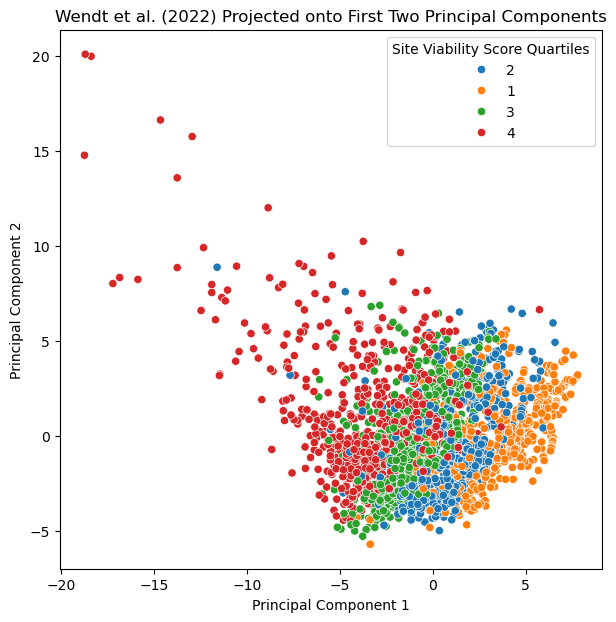

In [109]:
plt.figure(figsize = (7, 7))
plt.title("Wendt et al. (2022) Projected onto First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
ax = sns.scatterplot(x = wendt_2d[:, 0], y = wendt_2d[:, 1], hue = score_category)
ax.legend(title='Site Viability Score Quartiles');

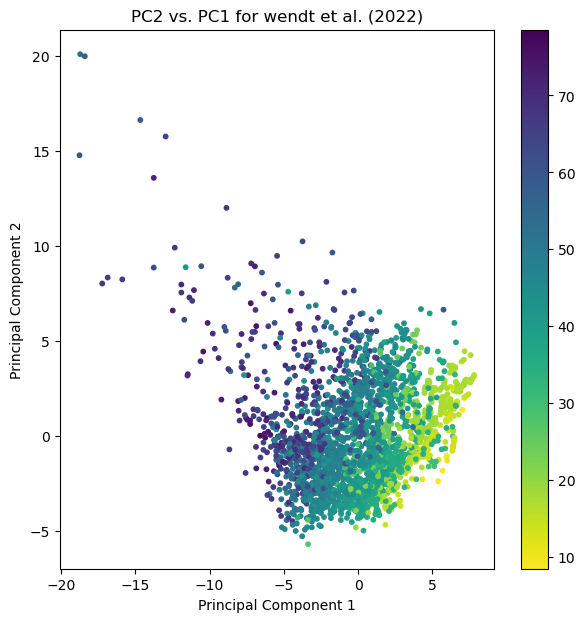

In [104]:
plt.figure(figsize = (7, 7))
plt.title("PC2 vs. PC1 for wendt et al. (2022)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
sc = plt.scatter(x = wendt_2d[:, 0], y = wendt_2d[:, 1], c = score_category2, s= 10, cmap='viridis_r')
cbar = plt.colorbar(sc);

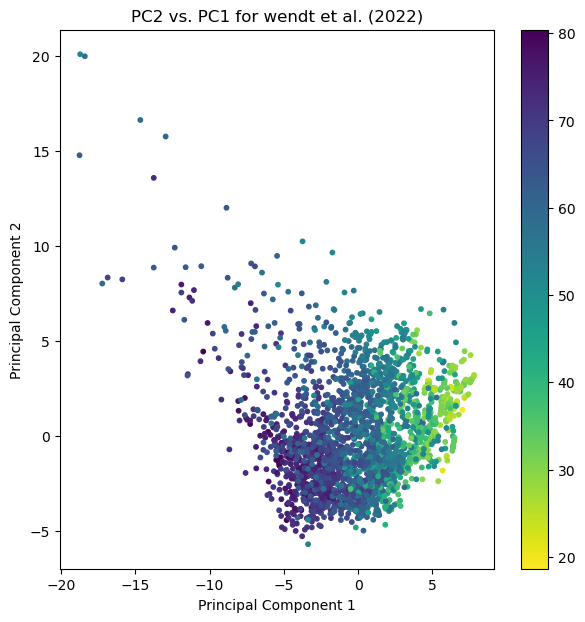

In [131]:
plt.figure(figsize = (7, 7))
plt.title("PC2 vs. PC1 for wendt et al. (2022)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
sc = plt.scatter(x = wendt_2d[:, 0], y = wendt_2d[:, 1], c = score_category1, s= 10, cmap='viridis_r')
cbar = plt.colorbar(sc);

Here, we can visualize the differences in space between lower and higher scoring sites, demonstrating that PCA is largely successful in separating different sites without these specific labels. Moving from right to left, sites score higher and higher, with the highest scoring sites on the far left. Although most sites are clumped together, many high scoring sites trail towards the top left, indicating an potential area of further analysis.

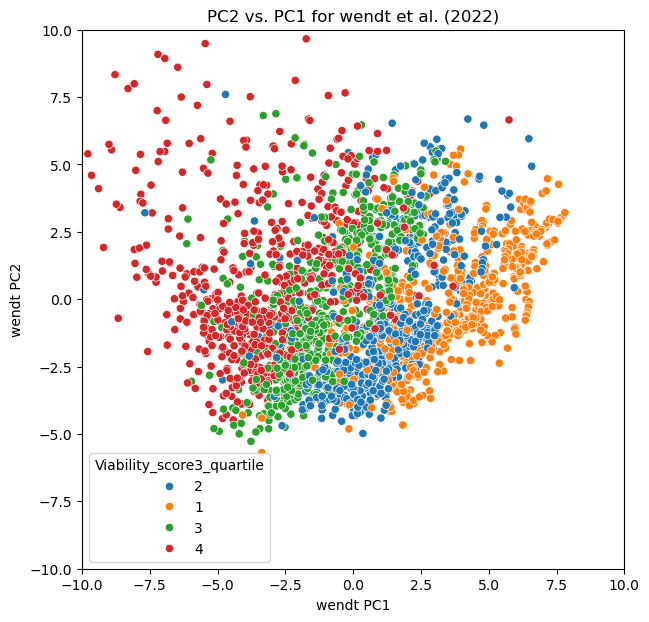

In [93]:
plt.figure(figsize = (7, 7))
plt.title("PC2 vs. PC1 for wendt et al. (2022)")
plt.xlabel("wendt PC1")
plt.ylabel("wendt PC2")
plt.xlim(-10, 10)
plt.ylim(-10, 10)
sns.scatterplot(x = wendt_2d[:, 0], y = wendt_2d[:, 1], hue = score_category);

After focusing in on the majority of the data, we can better identify trends of increasing site scores throughout space. Although there is no complete separation between clases, one can clearly see the fluidity of scores from left to right. There is also a much more defined distinction between the highest and lowest scores (far left and far right).
## PCA Analysis
To further determine the success of the PCA, I calculate the percent of total dataset variance captured by the first two principal components.

In [71]:
wendt_2d_variance = sum(np.var(wendt_2d, axis=0))/wendt_total_variance
wendt_2d_variance

0.37262740180128523

Only 37% of variance is captured using the first two principal components, demonstrating large variance loss.
## Scree Plot
Next, I create a Scree Plot to visualize the weight of each principal component.

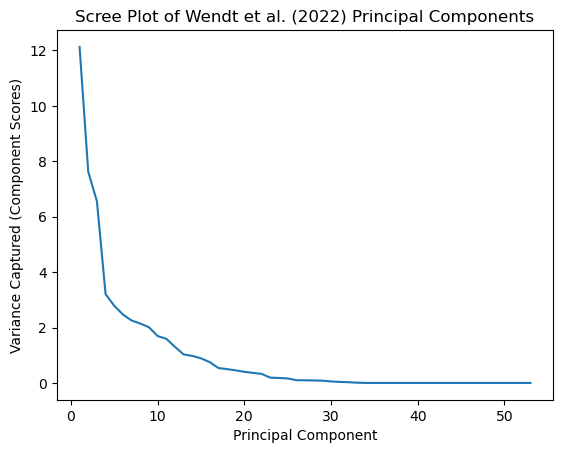

In [72]:
x= np.arange(1, 54)
y= s**2/len(wendt_pca_arr)
plt.plot(x, y)
plt.xlabel('Principal Component')
plt.ylabel('Variance Captured (Component Scores)')
plt.title('Scree Plot of Wendt et al. (2022) Principal Components') ;

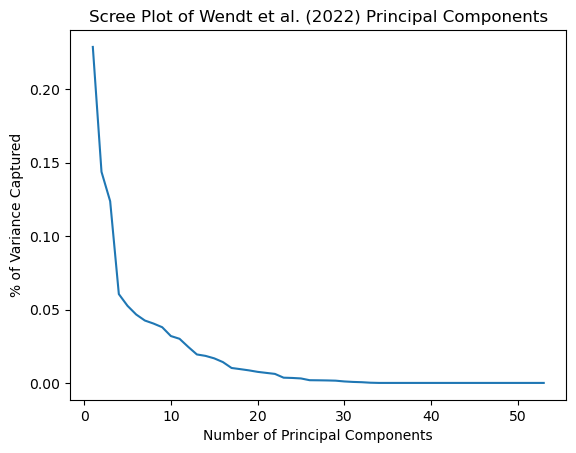

In [95]:
x= np.arange(1, 54)
y= s**2/len(wendt_pca_arr)/ wendt_total_variance
plt.plot(x, y)
plt.xlabel('Number of Principal Components')
plt.ylabel('% of Variance Captured')
plt.title('Scree Plot of Wendt et al. (2022) Principal Components') ;

Here, we can better vidualize the weighting of all principal components. It is clear that the first few principal components contribute to a majority of data variance. Despite 36% of total variance captured does not seem particularly high, when looking at all PC weighting, we can see that the first few are particularly beneficial.

Overall, this principal component analysis demonstrates high applications of unsupervised machine learning for CGS site valuation.

# Prediction Modeling of Site Score

In [110]:
wendt = wendt.drop(columns=['S1', 'Viability_score1_quartile'])

In [111]:
wendt.iloc[:, :-1]

,Distance (km),Distance (km).1,Distance (km).2,Caisson Platform,Fixed Platform,Well Protector Platform,Pipeline,Fault,Salt dome,Shipping Route (w/5 MI Buffer),...,Water depth - Saline Reservoirs,Subsea depth - Oil Reservoirs,Water depth - Oil Reservoirs,Above salt domes,Active Well Density,P&A Well Density,Faults,Sum of Reservoir Quality W/O Depth (feet),New Injectivity,S3
0,56.265652,39.710421,127.205047,0,0,0,1,0,0,1,...,64.8147,64.7705,64.8147,0.0,99.1011,98.3193,100.0,9.1271,12.3958,38.572100
1,50.940346,34.179635,117.880692,0,0,0,0,0,0,1,...,51.1750,67.0898,51.1750,0.0,100.0000,100.0000,100.0,1.5259,1.7557,16.120983
2,57.783507,41.034622,124.718795,0,0,0,1,0,0,1,...,64.8147,64.7705,64.8147,0.0,99.7753,99.5798,100.0,9.1271,12.3958,38.559063
3,53.574517,37.428918,115.740856,0,0,0,0,1,0,1,...,64.8147,64.7705,64.8147,0.0,100.0000,100.0000,0.0,9.1271,12.3958,14.222778
4,60.118581,43.774470,122.694148,0,0,0,1,0,0,1,...,64.8147,64.7705,64.8147,0.0,100.0000,100.0000,100.0,9.1271,12.3958,38.506005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2554,90.932440,76.494158,86.555143,0,0,0,0,0,0,1,...,47.2829,77.9115,47.2829,0.0,100.0000,100.0000,100.0,9.9857,11.2027,16.993804
2555,84.443641,68.570209,79.735503,0,0,0,0,0,0,1,...,51.4014,74.1428,51.4014,0.0,100.0000,100.0000,100.0,6.8179,5.9596,15.706714
2556,27.789683,17.932734,23.083298,0,0,0,1,0,0,1,...,68.9916,98.1641,68.9916,0.0,100.0000,100.0000,100.0,3.0173,8.4316,33.239677
2557,34.138032,15.290775,20.378109,0,0,0,1,0,0,1,...,64.5917,76.2837,64.5917,0.0,100.0000,100.0000,100.0,10.4977,13.0178,34.577485


First, I create a 70/30 train test split on **wendt**. 

In [112]:
X = wendt.iloc[:, :-2]
y = wendt['S3']

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [115]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf= rf.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred_rf))

MSE:  0.8294290173761918


In [39]:
wendt.columns

Index(['Distance (km)', 'Distance (km).1', 'Distance (km).2',
       'Caisson Platform', 'Fixed Platform', 'Well Protector Platform',
       'Pipeline', 'Fault', 'Salt dome', 'Shipping Route (w/5 MI Buffer)',
       'Shipping Route (w/10 mi Buffer)', 'Fault.1', 'Active Wells',
       'P&A Wells', 'Caisson Platform.1', 'Major Platform',
       'Well Protector Platform.1', 'Pipeline.1', 'Salt dome.1', 'EOR Wells',
       'Shipping Route (w/10 mi Buffer).1', 'Number of plays',
       '(SUM) Injectivity W Depth - (kh)',
       '(SUM) Quality W/O Depth - ([h x E]/[1,000 feet to reservoir bottom])',
       'Capacity per Grid - (million tonnes)', 'Water Depth - (feet)',
       'Average Calculated Water Depth - (feet)',
       '(SUM) Hydrocarbon Potential W/O Depth - ([h x So]/[1,000 feet to reservoir bottom])',
       'Recoverable Oil (barrels)/acre foot',
       '(Sum) Projected Remaining OIP - (barrels)',
       'New Injectivity (mD/MPa °K)', 'Subsea Depth - (feet)',
       'Average Calcula

In [42]:
#Create a function to visualize predicted vs actual test values

def Visualize(predictions, Model_name):
    plt.scatter(X_test['Sum of Reservoir Quality W/O Depth (feet)'], y_test, color='blue', label='Actual')
    plt.scatter(X_test['Sum of Reservoir Quality W/O Depth (feet)'], predictions, color='red', label='Predicted')
    plt.title(Model_name)
    plt.xlabel('Feature')
    plt.ylabel('Target')
    plt.legend()
    plt.show()

In [117]:
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, color='blue', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--')  # Line at y=0
    plt.xlabel('Predicted Values (y_pred)')
    plt.ylabel('Residuals (y_test - y_pred)')
    plt.title(f'{model_name} Residual Plot')
    plt.show()

In [116]:
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, y_pred)
    plt.plot(np.arange(10), np.arange(10), color='red', linestyle= '--')
#    plt.axhline(y=0, color='red', linestyle='--')  # Line at y=0
    plt.xlabel('Predicted Values (y_pred)')
    plt.ylabel('Residuals (y_test - y_pred)')
    plt.title(f'{model_name} Residual Plot')
    plt.show()

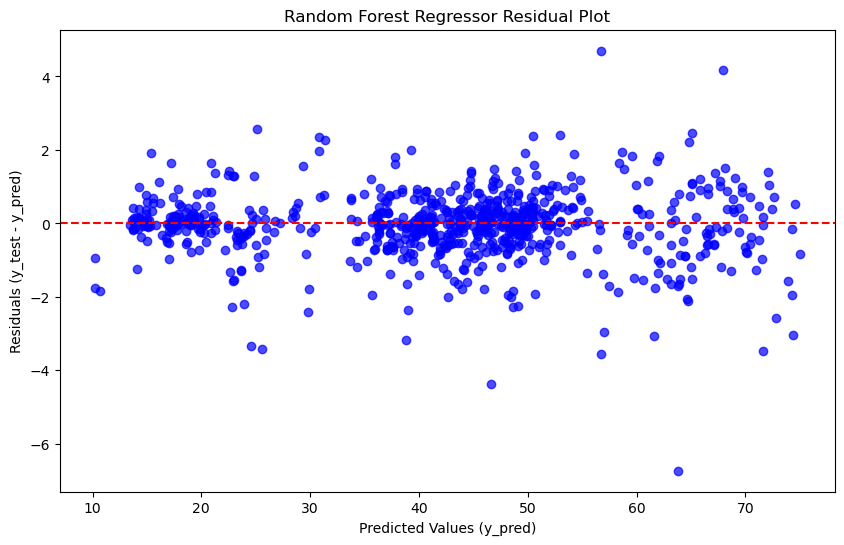

In [38]:
plot_residuals(y_test, y_pred_rf, 'Random Forest Regressor')

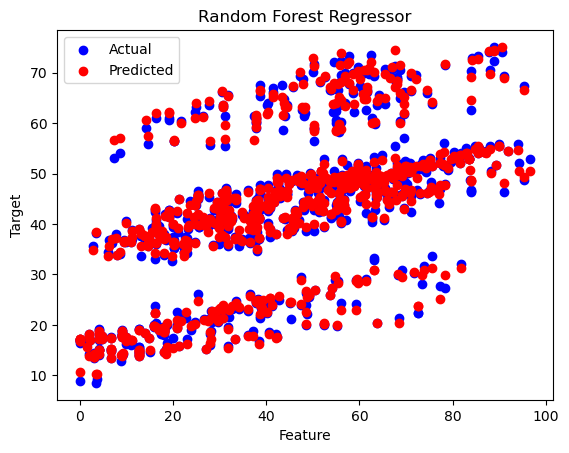

In [43]:
Visualize(y_pred_rf, 'Random Forest Regressor')

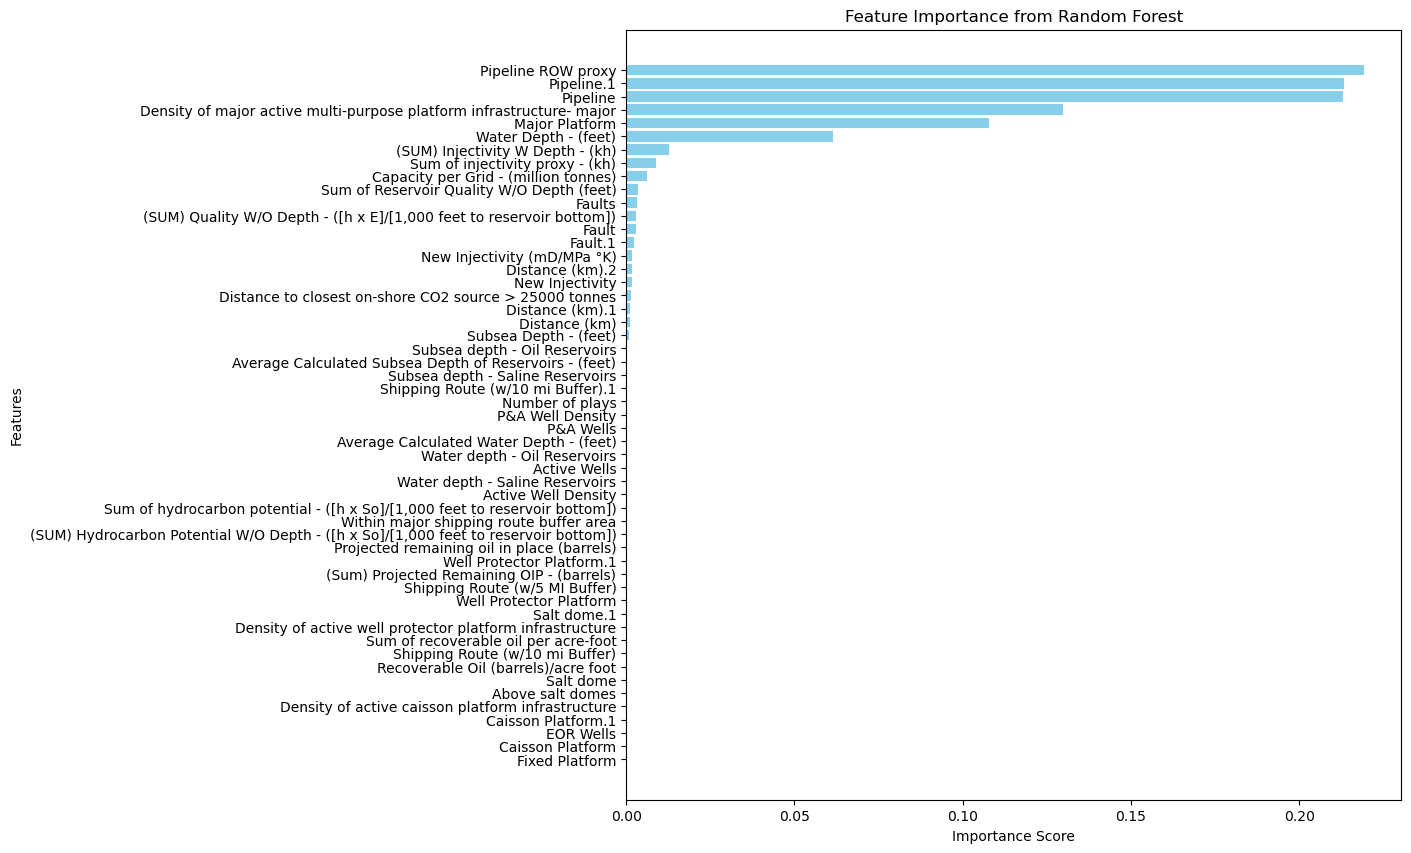

In [119]:
# Extract feature importance from the trained Random Forest model
importances = rf.feature_importances_
feature_names = X_train.columns 

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 10))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # To show the highest importance feature at the top
plt.show()

In [125]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(wendt_standardized)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [126]:
pca.explained_variance_ratio_

array([2.28844632e-01, 1.43782770e-01, 1.23751837e-01, 6.05007086e-02,
       5.25152598e-02, 4.65976169e-02, 4.25001512e-02, 4.04279384e-02,
       3.79465599e-02, 3.19280096e-02, 3.00583460e-02, 2.45579660e-02,
       1.93915214e-02, 1.84125249e-02, 1.67355967e-02, 1.41940162e-02,
       1.01835110e-02, 9.38837223e-03, 8.55812228e-03, 7.54400502e-03,
       6.83437698e-03, 6.14383789e-03, 3.57042275e-03, 3.38213729e-03,
       3.05323361e-03, 1.85311905e-03, 1.78514816e-03, 1.69402111e-03,
       1.53794086e-03, 1.00866052e-03, 6.79806147e-04, 4.92485802e-04,
       1.44211735e-04, 1.13344493e-06, 1.65885768e-13, 9.56169972e-14,
       4.59639187e-14, 4.20478241e-14, 3.68574416e-14, 3.35205871e-14,
       1.83510382e-14, 1.67530794e-14, 1.40857314e-14, 8.37733754e-15,
       2.76701093e-15, 6.42967933e-18, 2.47096590e-18, 5.96507919e-19,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [127]:
pca.singular_values_

array([1.76174660e+02, 1.39645357e+02, 1.29553427e+02, 9.05843784e+01,
       8.43948289e+01, 7.94977672e+01, 7.59221181e+01, 7.40480925e+01,
       7.17396549e+01, 6.58050162e+01, 6.38492231e+01, 5.77124185e+01,
       5.12836608e+01, 4.99723475e+01, 4.76424052e+01, 4.38758685e+01,
       3.71639483e+01, 3.56835643e+01, 3.40692303e+01, 3.19870406e+01,
       3.04454602e+01, 2.88664217e+01, 2.20055840e+01, 2.14174960e+01,
       2.03494696e+01, 1.58534847e+01, 1.55600222e+01, 1.51576714e+01,
       1.44425173e+01, 1.16962216e+01, 9.60208667e+00, 8.17278238e+00,
       4.42255638e+00, 3.92078736e-01, 1.49995297e-04, 1.13878209e-04,
       7.89553570e-05, 7.55170195e-05, 7.07026466e-05, 6.74262313e-05,
       4.98888390e-05, 4.76672833e-05, 4.37081857e-05, 3.37074644e-05,
       1.93721809e-05, 9.33829812e-07, 5.78903871e-07, 2.84433788e-07,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [129]:
wendt_2d_2= pca.transform(wendt_standardized)[:, :2]

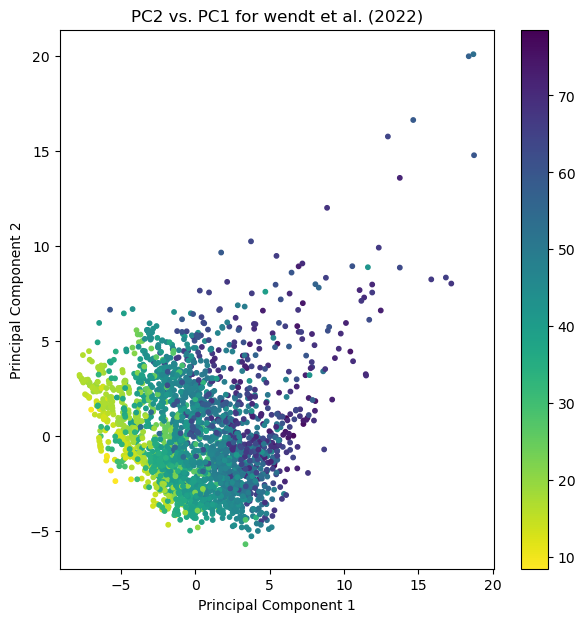

In [132]:
plt.figure(figsize = (7, 7))
plt.title("PC2 vs. PC1 for wendt et al. (2022)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
sc = plt.scatter(x = wendt_2d_2[:, 0], y = wendt_2d_2[:, 1], c = score_category2, s= 10, cmap='viridis_r')
cbar = plt.colorbar(sc);

In [136]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

regr = MLPRegressor()
regr.fit(X_train, y_train)
y_pred_nn = regr.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred_nn))


MSE:  179917952.46069252


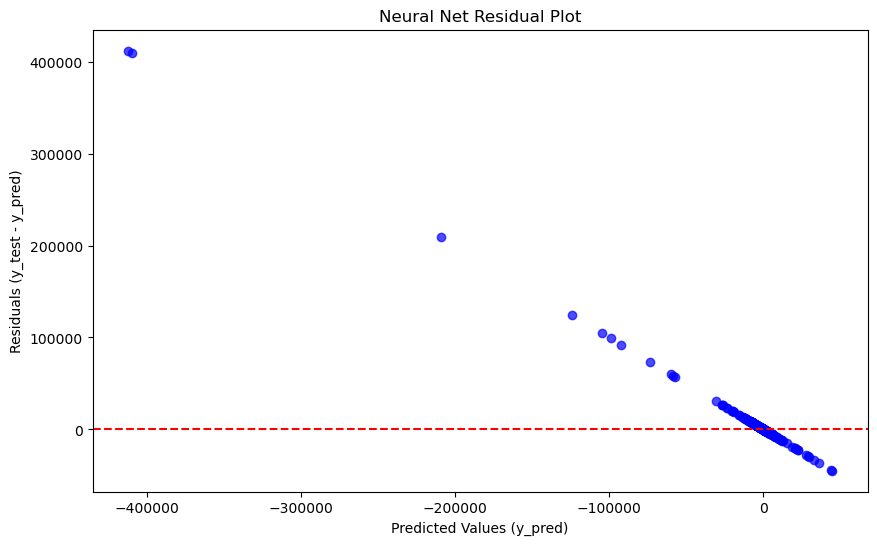

In [135]:
plot_residuals(y_test, y_pred_nn, 'Neural Net')

In [138]:
from sklearn import ensemble
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
mse

0.9204881422162673

In [139]:
reg = ensemble.GradientBoostingRegressor()
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
mse

0.6954876692177141

In [144]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr.fit(X_train, y_train)
mse = mean_squared_error(y_test, regr.predict(X_test))
mse

16.99678854703611